# **Import Libraries**

In [32]:
import os
import cv2
import shutil
import random
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import roc_auc_score, balanced_accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import warnings
warnings.filterwarnings('ignore')
from sklearn.utils import class_weight
from sklearn.metrics import precision_recall_curve

# **Preparing Dataset**

In [2]:
import tensorflow as tf
from google.colab import drive
drive.mount('/content/drive')
print("GPU Available: ", tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Mounted at /content/drive
GPU Available:  False


In [3]:
import os
import cv2

input_folder = "/content/drive/MyDrive/conjuctiva"
output_folder = "/content/drive/MyDrive/conjuctiva224"

# Membuat folder output jika belum ada
os.makedirs(output_folder, exist_ok=True)

categories = ["anemia", "non-anemia"]

for category in categories:
    category_input_folder = os.path.join(input_folder, category)
    category_output_folder = os.path.join(output_folder, category)
    os.makedirs(category_output_folder, exist_ok=True)

    images = os.listdir(category_input_folder)

    for image_name in images:
        image_path = os.path.join(category_input_folder, image_name)
        output_image_path = os.path.join(category_output_folder, image_name)

        if os.path.isfile(image_path):
            # Baca gambar
            img = cv2.imread(image_path)

            # Normalisasi ukuran menjadi 224x224
            img = cv2.resize(img, (224, 224))

            # Simpan gambar yang sudah dinormalisasi
            cv2.imwrite(output_image_path, img)

In [4]:
import os

output_folder = "/content/drive/MyDrive/conjuctiva224"

categories = ["anemia", "non-anemia"]

for category in categories:
    category_folder = os.path.join(output_folder, category)
    file_count = len(os.listdir(category_folder))
    print(f"Jumlah file pada folder {category}: {file_count}")

Jumlah file pada folder anemia: 2558
Jumlah file pada folder non-anemia: 2558


**Split Dataset**

In [5]:
import os
import shutil
import random

# Tentukan path dataset
dataset_path = "/content/drive/MyDrive/conjuctiva224"

# Tentukan path output untuk menyimpan dataset terbagi
output_path = "/content/drive/MyDrive/anemalyze"

# Buat direktori output jika belum ada
os.makedirs(output_path, exist_ok=True)

# Membaca nama file dari setiap kelas
anemia_files = os.listdir(os.path.join(dataset_path, "anemia"))
nonanemia_files = os.listdir(os.path.join(dataset_path, "non-anemia"))

# Menggabungkan semua kategori
all_files = {
    "anemia": anemia_files,
    "non-anemia": nonanemia_files,
}

# Mengacak urutan file di setiap kategori
for category in all_files:
    random.shuffle(all_files[category])

# Tentukan rasio pembagian dataset
train_ratio = 0.8
validation_ratio = 0.1
test_ratio = 0.1

# Memisahkan dataset menjadi bagian pelatihan, validasi, dan pengujian
train_data = {}
validation_data = {}
test_data = {}

for category, files in all_files.items():
    total_files = len(files)
    train_split = int(train_ratio * total_files)
    validation_split = int(validation_ratio * total_files)

    train_data[category] = files[:train_split]
    validation_data[category] = files[train_split:train_split+validation_split]
    test_data[category] = files[train_split+validation_split:]

# Fungsi untuk memindahkan file ke direktori output
def move_files(files, source_path, destination_path):
    for file in files:
        source_file = os.path.join(source_path, file)
        destination_file = os.path.join(destination_path, file)
        shutil.copyfile(source_file, destination_file)

# Memindahkan file ke direktori output
for category, files in train_data.items():
    source_path = os.path.join(dataset_path, category)
    destination_path = os.path.join(output_path, "train", category)
    os.makedirs(destination_path, exist_ok=True)
    move_files(files, source_path, destination_path)

for category, files in validation_data.items():
    source_path = os.path.join(dataset_path, category)
    destination_path = os.path.join(output_path, "validation", category)
    os.makedirs(destination_path, exist_ok=True)
    move_files(files, source_path, destination_path)

for category, files in test_data.items():
    source_path = os.path.join(dataset_path, category)
    destination_path = os.path.join(output_path, "test", category)
    os.makedirs(destination_path, exist_ok=True)
    move_files(files, source_path, destination_path)

print("Split Data Telah Selesai!")

Split Data Telah Selesai!


In [6]:
import os

train_folder = "/content/drive/MyDrive/anemalyze/train"
validation_folder = "/content/drive/MyDrive/anemalyze/validation"
test_folder = "/content/drive/MyDrive/anemalyze/test"

categories = ["anemia", "non-anemia"]

print("TRAIN")
for category in categories:
    category_folder = os.path.join(train_folder, category)
    file_count = len(os.listdir(category_folder))
    print(f"Jumlah file pada folder {category}: {file_count}")
print("VALIDATION")
for category in categories:
    category_folder = os.path.join(validation_folder, category)
    file_count = len(os.listdir(category_folder))
    print(f"Jumlah file pada folder {category}: {file_count}")
print("TEST")
for category in categories:
    category_folder = os.path.join(test_folder, category)
    file_count = len(os.listdir(category_folder))
    print(f"Jumlah file pada folder {category}: {file_count}")

TRAIN
Jumlah file pada folder anemia: 2046
Jumlah file pada folder non-anemia: 2046
VALIDATION
Jumlah file pada folder anemia: 255
Jumlah file pada folder non-anemia: 255
TEST
Jumlah file pada folder anemia: 257
Jumlah file pada folder non-anemia: 257


# **Build Model with MobileNetV2 and CNN**

In [7]:
train_dir = "/content/drive/MyDrive/anemalyze/train"
test_dir = "/content/drive/MyDrive/anemalyze/test"
val_dir = "/content/drive/MyDrive/anemalyze/validation"

input_shape = (224, 224)
num_classes = 2
batch_size = 64
epochs = 50

train_datagen = ImageDataGenerator(
                rescale=1./255,
                rotation_range=20,
                horizontal_flip=True,
                shear_range = 0.2,
                fill_mode = 'nearest')
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

validation_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='binary')

Found 4092 images belonging to 2 classes.
Found 514 images belonging to 2 classes.
Found 514 images belonging to 2 classes.


In [8]:
# Load MobileNetV2 without the top layers
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False  # Freeze base model layers initially

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [15]:
model = Sequential([
    base_model,
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [16]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.optimizers.Adam(learning_rate=1e-4),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 5, 5, 128)           │       1,474,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 2, 2, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,060,865 (15.49 MB)

 Trainable params: 1,802,881 (6.88 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [13]:
class myCallback(tf.keras.callbacks.Callback):
    def __init__(self, accuracy_threshold=0.8):
        super(myCallback, self).__init__()
        self.accuracy_threshold = accuracy_threshold

    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') and logs.get('accuracy') > self.accuracy_threshold:
            print(f"\nReached {self.accuracy_threshold * 100}% accuracy, stopping training!")
            self.model.stop_training = True

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

**Training model**

In [17]:
callbacks_list = [myCallback(accuracy_threshold=0.85), early_stop]

history = model.fit(
      train_generator,
      epochs=epochs,
      validation_data=validation_generator,
      callbacks=callbacks_list)

Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 357s 5s/step - accuracy: 0.5275 - loss: 0.9124 - val_accuracy: 0.5778 - val_loss: 0.6531
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 350s 5s/step - accuracy: 0.6242 - loss: 0.6464 - val_accuracy: 0.6479 - val_loss: 0.6347
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 337s 5s/step - accuracy: 0.6545 - loss: 0.6176 - val_accuracy: 0.6556 - val_loss: 0.6225
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 346s 5s/step - accuracy: 0.6688 - loss: 0.6009 - val_accuracy: 0.6848 - val_loss: 0.6024
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 338s 5s/step - accuracy: 0.7323 - loss: 0.5463 - val_accuracy: 0.6848 - val_loss: 0.5660
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 391s 5s/step - accuracy: 0.7436 - loss: 0.5185 - val_accuracy: 0.7004 - val_loss: 0.5872
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 371s 5s/step - accuracy: 0.7472 - loss: 0.4931 - val_accuracy: 0.7393 - val_loss: 0.5228
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 353s 5s/step - accuracy: 0.7948 - loss: 0.4506 - val_accuracy: 0.7354 - v

**Review the learning curves**

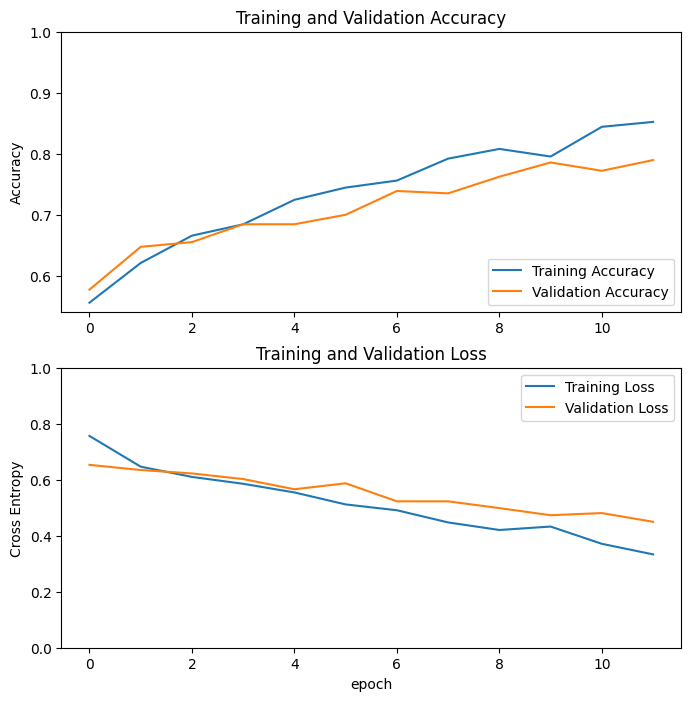

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

**Fine Tune**

In [20]:
base_model.trainable = True
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [21]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [22]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 5, 5, 128)           │       1,474,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 2, 2, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,060,865 (15.49 MB)

 Trainable params: 3,664,321 (13.98 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [23]:
history_fine = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=[myCallback(accuracy_threshold=0.9)]
)

Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 533s 8s/step - accuracy: 0.5951 - loss: 0.8679 - val_accuracy: 0.8268 - val_loss: 0.4297
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 547s 8s/step - accuracy: 0.6355 - loss: 0.6753 - val_accuracy: 0.8366 - val_loss: 0.4434
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 501s 8s/step - accuracy: 0.6754 - loss: 0.6000 - val_accuracy: 0.8230 - val_loss: 0.4547
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 483s 7s/step - accuracy: 0.7088 - loss: 0.5643 - val_accuracy: 0.8074 - val_loss: 0.4706
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 458s 7s/step - accuracy: 0.7248 - loss: 0.5370 - val_accuracy: 0.8132 - val_loss: 0.4747
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 424s 6s/step - accuracy: 0.7574 - loss: 0.5010 - val_accuracy: 0.7899 - val_loss: 0.4998
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 431s 7s/step - accuracy: 0.7671 - loss: 0.4867 - val_accuracy: 0.7840 - val_loss: 0.5045
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 446s 7s/step - accuracy: 0.7990 - loss: 0.4526 - val_accuracy: 0.7802 - v

**Review the learning curves**

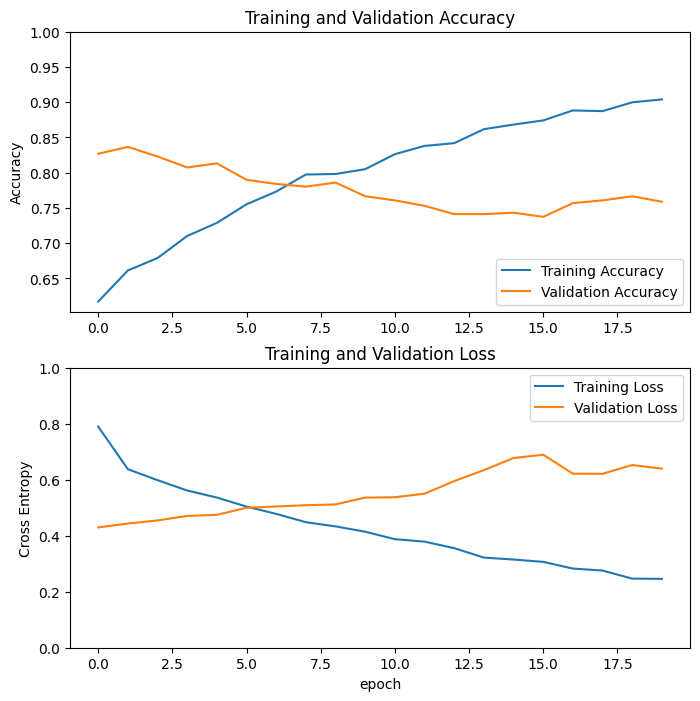

In [24]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# **Save Model**

In [25]:
MODEL_BASE_PATH = "/content/drive/MyDrive/"
PROJECT_NAME = "model_project"
SAVE_MODEL_NAME = "anemalyze_model.h5"
save_model_path = os.path.join(MODEL_BASE_PATH, PROJECT_NAME, SAVE_MODEL_NAME)

if os.path.exists(os.path.join(MODEL_BASE_PATH, PROJECT_NAME)) == False:
    os.makedirs(os.path.join(MODEL_BASE_PATH, PROJECT_NAME))

print('Saving Model At {}...'.format(save_model_path))
model.save(save_model_path,include_optimizer=False)

Saving Model At /content/drive/MyDrive/model_project/anemalyze_model.h5...


# **Convert to TFLite**

In [38]:
# A generator that provides a representative dataset
def representative_data_gen():
  dataset_path = "/content/drive/MyDrive/conjuctiva224"
  dataset_list = tf.data.Dataset.list_files(dataset_path+ '/*/*')
  for i in range(100):
    image = next(iter(dataset_list))
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image / 255., tf.float32)
    image = tf.expand_dims(image, 0)
    yield [image]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
# This enables quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# This sets the representative dataset for quantization
converter.representative_dataset = representative_data_gen
# This ensures that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# For full integer quantization, though supported types defaults to int8 only, we explicitly declare it for clarity.
converter.target_spec.supported_types = [tf.int8]
# These set the input and output tensors to uint8 (added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
tflite_model = converter.convert()

with open('/content/drive/MyDrive/model_project/anemalyze_quant.tflite', 'wb') as f:
  f.write(tflite_model)

Saved artifact at '/tmp/tmpahfebzru'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_164')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  138218262446672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138218159642000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138218159638304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138218159640240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138218159641120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138218159647984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138218159646928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138218159649392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138218159639712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138218159648160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1382185708

In [39]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>


In [48]:
# Memuat model TFLite dan melakukan inference
interpreter = tf.lite.Interpreter(model_path='/content/drive/MyDrive/model_project/anemalyze_quant.tflite')
interpreter.allocate_tensors()

# Melakukan inference untuk memastikan model berjalan dengan benar
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Get the expected input shape from input_details
input_shape = input_details[0]['shape']

# Generate random data with the correct shape and data type
input_data = np.array(np.random.random_sample(input_shape) * 255, dtype=np.uint8)

interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()

output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

[[198]]
